In [5]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler1=StandardScaler()
scaler2= MinMaxScaler()
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, concatenate, Dropout
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [25]:
# Load the data
df = pd.read_excel('pc_cleaned_2_holiday_season.xlsx')
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df.set_index('Datetime', inplace=True)

# Split the data into train and test sets
train = df[df['Month'] <= 10]
test = df[df['Month'] > 10]

# Define the features and target
X_train = train[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season']]
y_train = np.sqrt(train['PowerConsumption_Zone1'])
X_test = test[['Temperature',  'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season']]
y_test = np.sqrt(test['PowerConsumption_Zone1'])



In [7]:
tscv = TimeSeriesSplit( max_train_size=4320*3, n_splits=8,test_size=4320)# 144 samples per day * 30 days = 4320 samples


In [4]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', LGBMRegressor())
])

# Define the parameter grid for grid search
param_grid = {
    'lgbm__n_estimators': [100, 200],
    'lgbm__learning_rate': [0.1, 0.01],
    'lgbm__max_depth': [3, 5],
    'lgbm__colsample_bytree': [0.8, 1.0]  # Include colsample_bytree parameter here
}


In [25]:
# Perform grid search using GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv,n_jobs=-1 )
grid_result = grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_result.best_estimator_


In [26]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'lgbm__colsample_bytree': 0.8, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 100}


In [27]:
# Make predictions with the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [28]:

# Merge y_train_pred and X_train
X_train_merged = pd.concat([pd.DataFrame(y_train_pred, columns=['Predicted']), X_train.reset_index(drop=True)], axis=1)

# Merge y_test_pred and X_test
X_test_merged = pd.concat([pd.DataFrame(y_test_pred, columns=['Predicted']), X_test.reset_index(drop=True)], axis=1)


In [29]:
X_train_merged_normalized = scaler1.fit_transform(X_train_merged)
X_train_merged_reshaped = np.reshape(X_train_merged_normalized, (X_train_merged_normalized.shape[0], 1, X_train_merged_normalized.shape[1]))
# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64,activation='sigmoid', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

 
# Define a custom transformer for reshaping
class ReshapeTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.reshape(X, (X.shape[0], 1, X.shape[1]))
    
# Define the pipeline
# Define the pipeline
pipeline = Pipeline([
    ('scaler', scaler1),
    ('reshape', ReshapeTransformer()),
   ('lstm', KerasRegressor(model=create_lstm_model, epochs=50, batch_size=32, optimizer='adam'))
])
param_grid = {  }

In [ ]:


# Perform grid search using GridSearchCV with TimeSeriesSplit and the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)
grid_search.fit(X_train_merged, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test_merged)


In [24]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'lstm__batch_size': 32}


In [ ]:
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

In [ ]:
# Create a DataFrame to store the predicted values
df = pd.DataFrame({'power_consumption_prediction': y_pred})

# Specify the Excel file name and path
excel_file_path = 'hybrid_std.xlsx'

# Save the DataFrame to Excel
df.to_excel(excel_file_path, index=False)

In [12]:
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 124.31053983844936
MAE: 9.501716241329225
R-squared: 0.6034545401991395


## residual plot

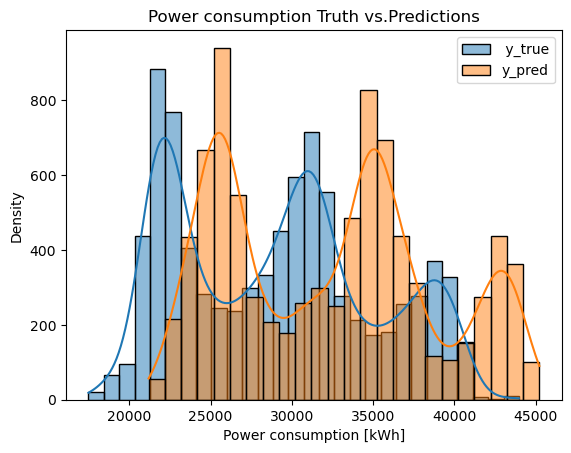

In [16]:
# Histplot of The actudal and the predicted grades
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(y_test**2, label=' y_true', kde=True, line_kws={'color': 'green'})
sns.histplot(y_pred**2, label='y_pred', kde=True, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Power consumption [kWh]')
plt.ylabel('Density')
plt.title('Power consumption Truth vs.Predictions')

# Set the y-axis tick locations and labels
#plt.xticks([i/2 for i in range(21)])

#plt.xlim(15000, 45000)

# Add legend
plt.legend()

# Display the plot
plt.show()

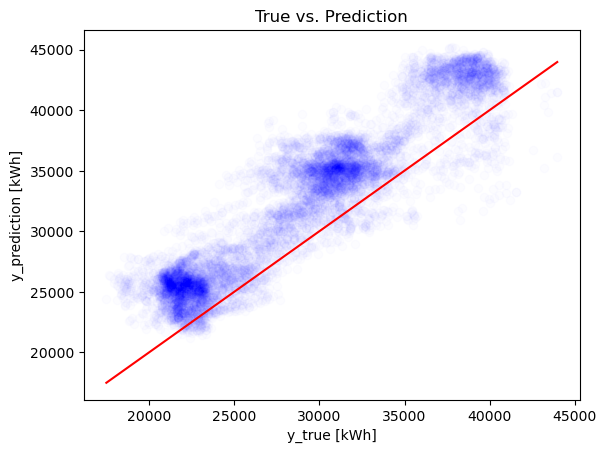

In [21]:
# Plot actual Vs. Predicted 



import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.scatter(y_test**2, y_pred**2, color='blue', alpha=0.01)

# Add a diagonal line indicating perfect predictions
plt.plot([min(y_test**2), max(y_test**2)], [min(y_test**2), max(y_test**2)], color='red')

# Set plot labels and title
plt.xlabel('y_true [kWh]')
plt.ylabel('y_prediction [kWh]')
plt.title('True vs. Prediction')

# Display the plot
plt.show()

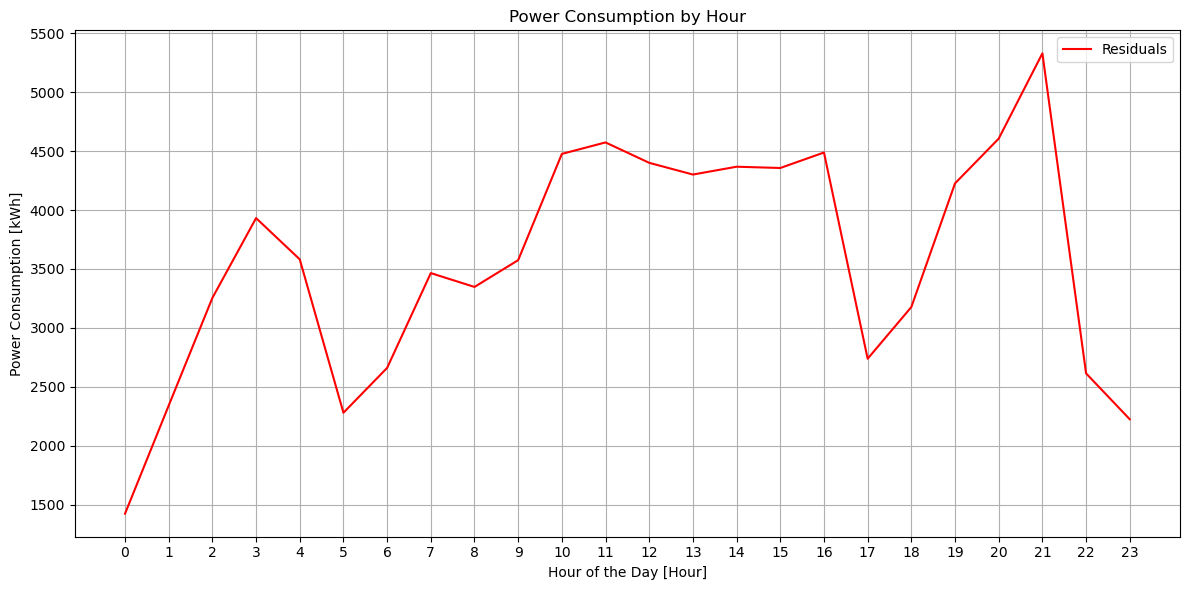

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test)
residuals =abs( y_pred**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour = residuals.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())



# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))


# Plot the residual line
ax.plot(hours, residuals_by_hour.values, label='Residuals', color='red')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


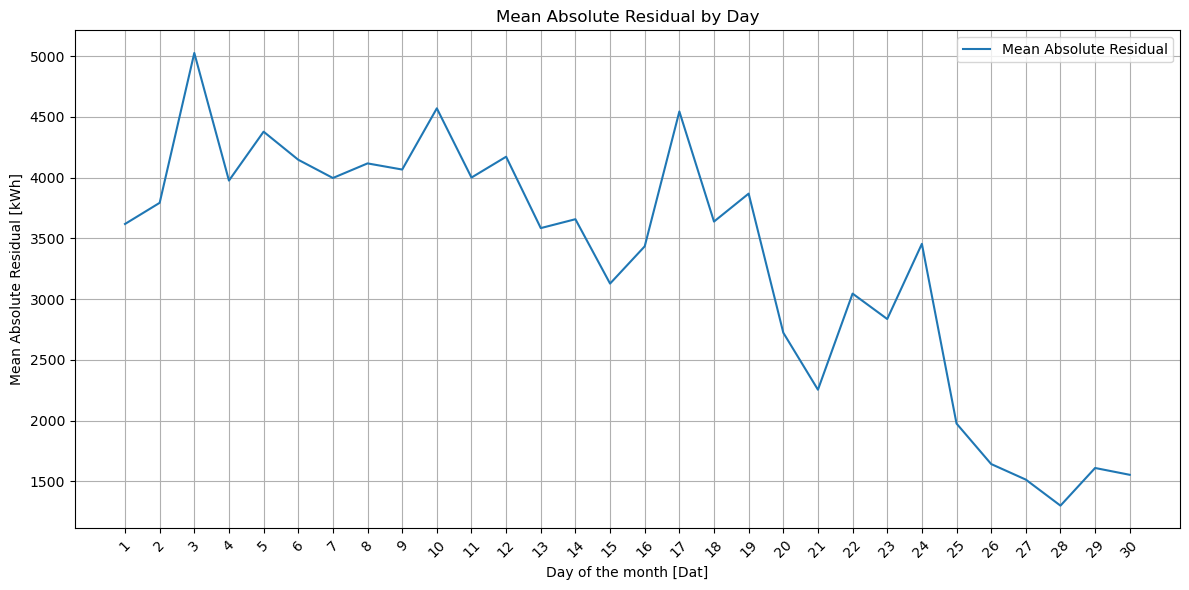

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Create a DataFrame with the daily data and residuals
daily_data = pd.DataFrame({'Day': X_test['Day'], 'Residuals': abs(residuals)})

# Group the data by 'Day' and calculate the mean absolute residual
mean_abs_residuals = daily_data.groupby('Day')['Residuals'].mean()

# Get the unique days
days = mean_abs_residuals.index

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean absolute residual against the 'Day'
ax.plot(days, mean_abs_residuals.values, label='Mean Absolute Residual')

# Set labels and title
ax.set_xlabel('Day of the month [Dat]')
ax.set_ylabel('Mean Absolute Residual [kWh]')
ax.set_title('Mean Absolute Residual by Day')

# Set x-axis tick labels
ax.set_xticks(days)
ax.set_xticklabels([str(day) for day in days], rotation=45)

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


## min max scaler

In [18]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lgbm', LGBMRegressor())
])

# Define the parameter grid for grid search
param_grid = {
    'lgbm__n_estimators': [100, 200],
    'lgbm__learning_rate': [0.1, 0.01],
    'lgbm__max_depth': [3, 5],
    'lgbm__colsample_bytree': [0.8, 1.0]  # Include colsample_bytree parameter here
}


In [19]:
# Perform grid search using GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv )
grid_result = grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_result.best_estimator_


In [20]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'lgbm__colsample_bytree': 1.0, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 100}


In [21]:
# Make predictions with the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [22]:

# Merge y_train_pred and X_train
X_train_merged = pd.concat([pd.DataFrame(y_train_pred, columns=['Predicted']), X_train.reset_index(drop=True)], axis=1)

# Merge y_test_pred and X_test
X_test_merged = pd.concat([pd.DataFrame(y_test_pred, columns=['Predicted']), X_test.reset_index(drop=True)], axis=1)


In [23]:
X_train_merged_normalized = scaler2.fit_transform(X_train_merged)
X_train_merged_reshaped = np.reshape(X_train_merged_normalized, (X_train_merged_normalized.shape[0], 1, X_train_merged_normalized.shape[1]))
# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(X_train_merged_reshaped.shape[1], X_train_merged_reshaped.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
 
# Define a custom transformer for reshaping
class ReshapeTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.reshape(X, (X.shape[0], 1, X.shape[1]))
    
# Define the pipeline
pipeline = Pipeline([
    ('scaler', scaler2),
    ('reshape', ReshapeTransformer()),
    ('lstm', KerasRegressor(model=create_lstm_model))
])


# Define the parameter grid for grid search
param_grid = {
    'lstm__batch_size': [32, 64],
    'lstm__epochs': [10, 20],
}

In [24]:
# Perform grid search using GridSearchCV with TimeSeriesSplit and the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(X_train_merged, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test_merged)


Epoch 1/10
288/288 [==============================] - 5s 4ms/step - loss: 28288.0137
Epoch 2/10
288/288 [==============================] - 1s 4ms/step - loss: 20825.2500
Epoch 3/10
288/288 [==============================] - 1s 4ms/step - loss: 15730.1670
Epoch 4/10
288/288 [==============================] - 1s 4ms/step - loss: 12100.0664
Epoch 5/10
288/288 [==============================] - 1s 4ms/step - loss: 9308.3945
Epoch 6/10
288/288 [==============================] - 1s 4ms/step - loss: 7106.4634
Epoch 7/10
288/288 [==============================] - 1s 4ms/step - loss: 5361.0215
Epoch 8/10
288/288 [==============================] - 1s 4ms/step - loss: 3986.7339
Epoch 9/10
288/288 [==============================] - 1s 4ms/step - loss: 2919.5085
Epoch 10/10
135/135 [==============================] - 1s 2ms/step
Epoch 1/10
405/405 [==============================] - 6s 4ms/step - loss: 26681.5684
Epoch 2/10
405/405 [==============================] - 2s 4ms/step - loss: 17616.3672
Epo

405/405 [==============================] - 1s 3ms/step - loss: 5055.3364
Epoch 7/20
405/405 [==============================] - 1s 3ms/step - loss: 3363.6055
Epoch 8/20
405/405 [==============================] - 1s 3ms/step - loss: 2169.4473
Epoch 9/20
405/405 [==============================] - 1s 3ms/step - loss: 1369.4218
Epoch 10/20
405/405 [==============================] - 1s 3ms/step - loss: 872.2419
Epoch 11/20
405/405 [==============================] - 1s 2ms/step - loss: 591.8803
Epoch 12/20
405/405 [==============================] - 1s 3ms/step - loss: 452.0782
Epoch 13/20
405/405 [==============================] - 1s 3ms/step - loss: 392.0668
Epoch 14/20
405/405 [==============================] - 1s 2ms/step - loss: 369.4750
Epoch 15/20
405/405 [==============================] - 1s 2ms/step - loss: 358.7244
Epoch 16/20
405/405 [==============================] - 1s 2ms/step - loss: 315.9840
Epoch 17/20
405/405 [==============================] - 1s 3ms/step - loss: 192.3473
Epo

203/203 [==============================] - 1s 3ms/step - loss: 4226.1265
Epoch 12/20
203/203 [==============================] - 1s 3ms/step - loss: 3405.8789
Epoch 13/20
203/203 [==============================] - 1s 3ms/step - loss: 2721.9871
Epoch 14/20
203/203 [==============================] - 1s 3ms/step - loss: 2158.5776
Epoch 15/20
203/203 [==============================] - 1s 3ms/step - loss: 1701.2344
Epoch 16/20
203/203 [==============================] - 1s 3ms/step - loss: 1336.3643
Epoch 17/20
203/203 [==============================] - 1s 3ms/step - loss: 1051.0361
Epoch 18/20
203/203 [==============================] - 1s 3ms/step - loss: 833.0447
Epoch 19/20
203/203 [==============================] - 1s 3ms/step - loss: 671.1776
Epoch 20/20
68/68 [==============================] - 1s 2ms/step
Epoch 1/20
203/203 [==============================] - 3s 3ms/step - loss: 30176.6719
Epoch 2/20
203/203 [==============================] - 1s 3ms/step - loss: 24455.5117
Epoch 3/20
203

In [25]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'lstm__batch_size': 32, 'lstm__epochs': 20}


In [26]:
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 139.3742312274745
MAE: 10.533185300061914
R-squared: 0.5554019902229094


## residual plot

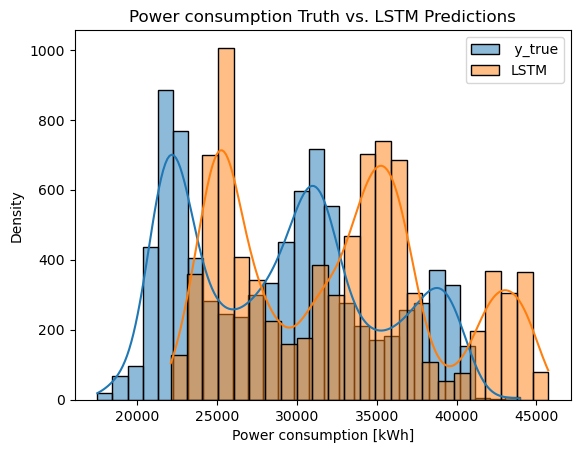

In [27]:
# Histplot of The actudal and the predicted grades
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(y_test**2, label=' y_true', kde=True, line_kws={'color': 'green'})
sns.histplot(y_pred**2, label='LSTM', kde=True, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Power consumption [kWh]')
plt.ylabel('Density')
plt.title('Power consumption Truth vs. LSTM Predictions')

# Set the y-axis tick locations and labels
#plt.xticks([i/2 for i in range(21)])

#plt.xlim(15000, 45000)

# Add legend
plt.legend()

# Display the plot
plt.show()

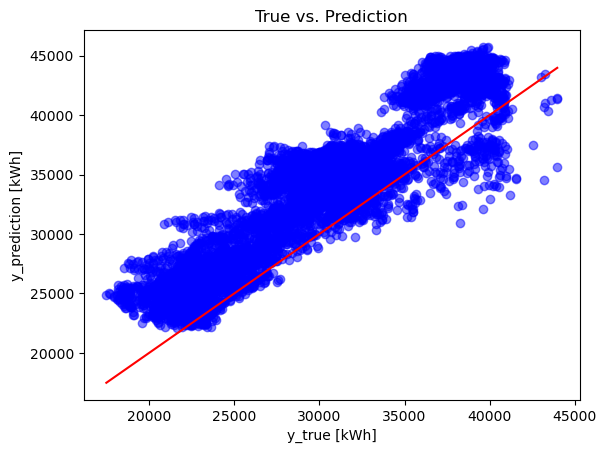

In [28]:
# Plot actual Vs. Predicted 



import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.scatter(y_test**2, y_pred**2, color='blue', alpha=0.5)

# Add a diagonal line indicating perfect predictions
plt.plot([min(y_test**2), max(y_test**2)], [min(y_test**2), max(y_test**2)], color='red')

# Set plot labels and title
plt.xlabel('y_true [kWh]')
plt.ylabel('y_prediction [kWh]')
plt.title('True vs. Prediction')

# Display the plot
plt.show()


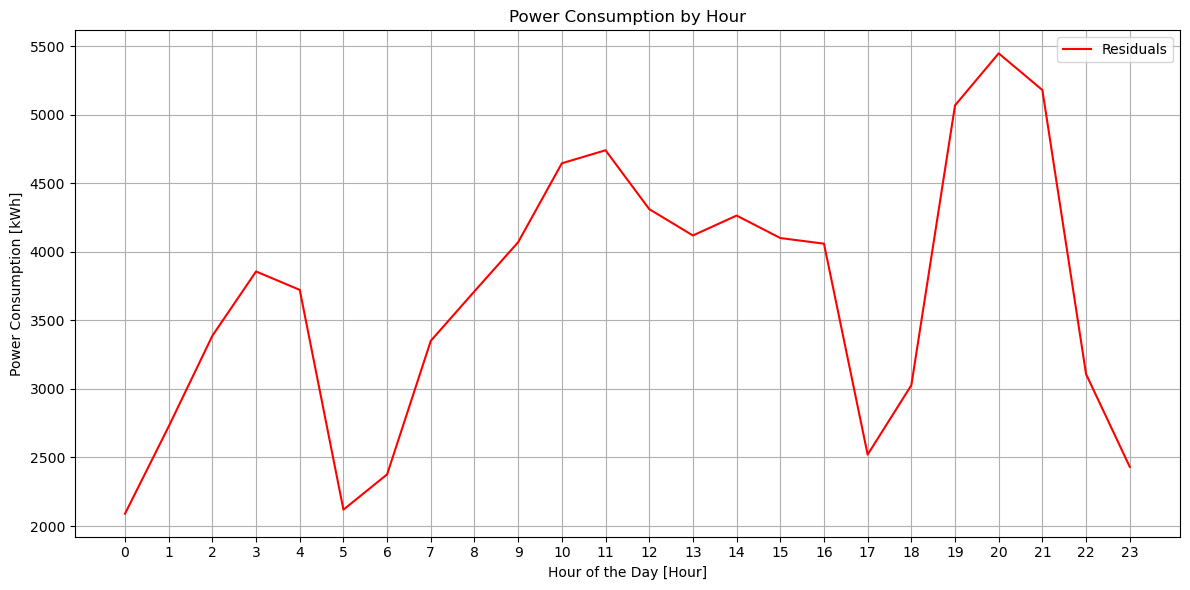

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour = residuals.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())



# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))


# Plot the residual line
ax.plot(hours, residuals_by_hour.values, label='Residuals', color='red')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


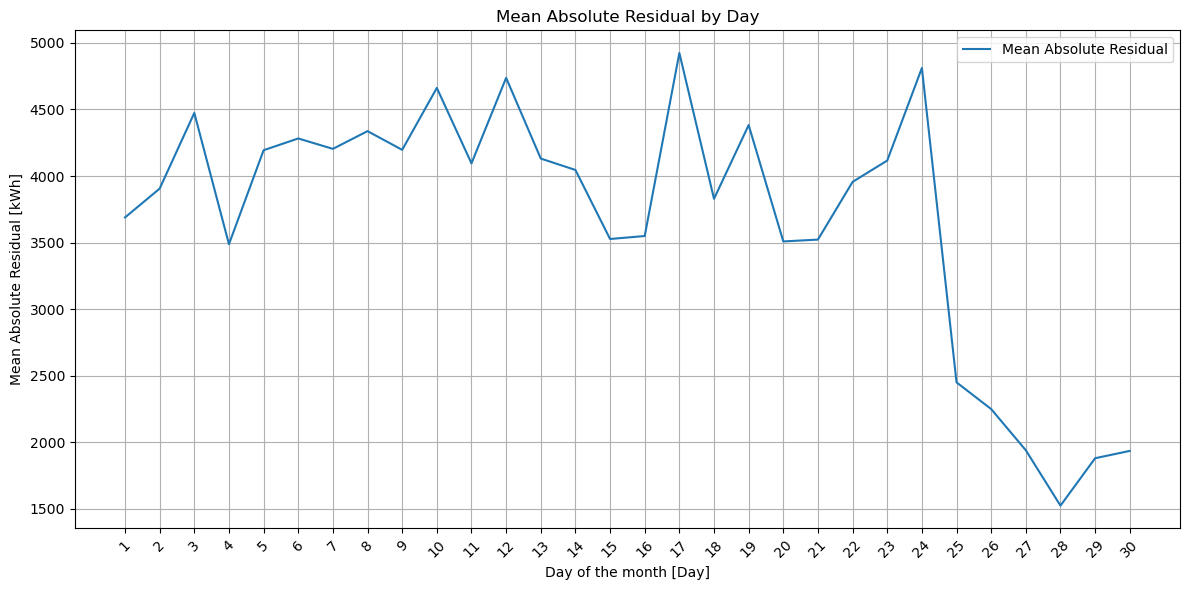

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Create a DataFrame with the daily data and residuals
daily_data = pd.DataFrame({'Day': X_test['Day'], 'Residuals': abs(residuals)})

# Group the data by 'Day' and calculate the mean absolute residual
mean_abs_residuals = daily_data.groupby('Day')['Residuals'].mean()

# Get the unique days
days = mean_abs_residuals.index

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean absolute residual against the 'Day'
ax.plot(days, mean_abs_residuals.values, label='Mean Absolute Residual')

# Set labels and title
ax.set_xlabel('Day of the month [Day]')
ax.set_ylabel('Mean Absolute Residual [kWh]')
ax.set_title('Mean Absolute Residual by Day')

# Set x-axis tick labels
ax.set_xticks(days)
ax.set_xticklabels([str(day) for day in days], rotation=45)

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


## lightgbm standard scaler+ lstm minmax

In [27]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', LGBMRegressor())
])

# Define the parameter grid for grid search
param_grid = {
    'lgbm__n_estimators': [100, 200],
    'lgbm__learning_rate': [0.1, 0.01],
    'lgbm__max_depth': [3, 5],
    'lgbm__colsample_bytree': [0.8, 1.0]  # Include colsample_bytree parameter here
}


In [28]:
# Perform grid search using GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv,n_jobs=-1 )
grid_result = grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_result.best_estimator_


In [29]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'lgbm__colsample_bytree': 0.8, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 100}


In [30]:
# Make predictions with the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


In [31]:
X_train=train[ ['Temperature', 'Humidity', 'GeneralDiffuseFlows', 'Month', 'Hour']]
X_test=test[ ['Temperature', 'Humidity', 'GeneralDiffuseFlows', 'Month', 'Hour']]

In [32]:

# Merge y_train_pred and X_train
X_train_merged = pd.concat([pd.DataFrame(y_train_pred, columns=['Predicted']), X_train.reset_index(drop=True)], axis=1)

# Merge y_test_pred and X_test
X_test_merged = pd.concat([pd.DataFrame(y_test_pred, columns=['Predicted']), X_test.reset_index(drop=True)], axis=1)

In [36]:
X_train_merged_normalized = scaler2.fit_transform(X_train_merged)
X_train_merged_reshaped = np.reshape(X_train_merged_normalized, (X_train_merged_normalized.shape[0], 1, X_train_merged_normalized.shape[1]))
# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64,activation='sigmoid', input_shape=(X_train_merged_reshaped.shape[1], X_train_merged_reshaped.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define a custom transformer for reshaping
class ReshapeTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.reshape(X, (X.shape[0], 1, X.shape[1]))
    
# Define the pipeline
pipeline = Pipeline([
    ('scaler', scaler2),
    ('reshape', ReshapeTransformer()),
   ('lstm', KerasRegressor(model=create_lstm_model, epochs=50, batch_size=32, optimizer='adam'))
])
param_grid = {  }


In [ ]:


# Perform grid search using GridSearchCV with TimeSeriesSplit and the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv,n_jobs=-1)
grid_search.fit(X_train_merged, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred3 = best_model.predict(X_test_merged)


Epoch 1/50
1368/1368 [==============================] - 12s 5ms/step - loss: 22294.5254
Epoch 2/50
1368/1368 [==============================] - 5s 4ms/step - loss: 7280.0107
Epoch 3/50
1368/1368 [==============================] - 5s 4ms/step - loss: 1897.2749
Epoch 4/50
1368/1368 [==============================] - 4s 3ms/step - loss: 507.5849
Epoch 5/50
1368/1368 [==============================] - 4s 3ms/step - loss: 323.2458
Epoch 6/50
1368/1368 [==============================] - 5s 4ms/step - loss: 148.3603
Epoch 7/50
1368/1368 [==============================] - 6s 4ms/step - loss: 72.5542
Epoch 8/50
1368/1368 [==============================] - 5s 4ms/step - loss: 49.6544
Epoch 9/50
1368/1368 [==============================] - 5s 3ms/step - loss: 41.5973
Epoch 10/50
1368/1368 [==============================] - 4s 3ms/step - loss: 38.6497
Epoch 11/50
1368/1368 [==============================] - 3s 2ms/step - loss: 37.5422
Epoch 12/50
1368/1368 [==============================] - 4s 3ms

In [ ]:
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred3)
mae = mean_absolute_error(y_test, y_pred3)
r2 = r2_score(y_test, y_pred3)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

In [ ]:
print("Best Hyperparameters:", grid_search.best_params_)

In [ ]:
# Create a DataFrame with the predictions
predictions_df = pd.DataFrame({'Predicted_PowerConsumption_Zone1': y_pred})

# Save the predictions DataFrame to an Excel file
output_excel_file = 'hybrid-std-min-rfe-predictions.xlsx'
predictions_df.to_excel(output_excel_file, index=False)